<a href="https://colab.research.google.com/github/LeoBaro/phd/blob/main/rtapipe/analysis/Untitled.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
! python3 -c 'import tensorflow as tf; print(tf.__version__)'  # for Python 3

2021-03-22 15:20:00.494819: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-03-22 15:20:00.494875: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2.4.1


# Sequence-to-Sequence Prediction Problems
Sequence prediction often involves forecasting the next value in a real valued sequence or outputting a class label for an input sequence.

This is often framed as a sequence of one input time step to one output time step (e.g. one-to-one) or multiple input time steps to one output time step (many-to-one) type sequence prediction problem.

One approach to seq2seq prediction problems that has proven very effective is called the Encoder-Decoder LSTM.

## Encoder-Decoder LSTM 
The LSTM network can be organized into an architecture called the Encoder-Decoder LSTM that allows the model to be used to both support variable length input sequences and to predict or output variable length output sequences.

In this architecture, an encoder LSTM model reads the input sequence step-by-step. After reading in the entire input sequence, the hidden state or output of this model represents an internal learned representation of the entire input sequence as a fixed-length vector. This vector is then provided as an input to the decoder model that interprets it as each step in the output sequence is generated
This architecture is comprised of two models: one for reading the input sequence and encoding it into a fixed-length vector, and a second for decoding the fixed-length vector and outputting the predicted sequence. The use of the models in concert gives the architecture its name of Encoder-Decoder LSTM designed specifically for seq2seq problems.
The innovation of this architecture is the use of a fixed-sized internal representation in the heart of the model that input sequences are read to and output sequences are read from. For this reason, the method may be referred to as sequence embedding.

    … RNN Encoder-Decoder, consists of two recurrent neural networks (RNN) that act as an encoder and a decoder pair. The encoder maps a variable-length source sequence to a fixed-length vector, and the decoder maps the vector representation back to a variable-length target sequence.

    — Learning Phrase Representations using RNN Encoder-Decoder for Statistical Machine Translation, 2014.

The Encoder-Decoder LSTM was developed for natural language processing problems where it demonstrated state-of-the-art performance, specifically in the area of text translation called statistical machine translation. 

    The proposed RNN Encoder-Decoder naturally generates a continuous-space representation of a phrase. […] From the visualization, it is clear that the RNN Encoder-Decoder captures both semantic and syntactic structures of the phrases

    — Learning Phrase Representations using RNN Encoder-Decoder for Statistical Machine Translation, 2014.

## Keras implementation

For a given dataset of sequences, an encoder-decoder LSTM is configured to read the input sequence, encode it, decode it, and recreate it. The performance of the model is evaluated based on the model’s ability to recreate the input sequence.

Once the model achieves a desired level of performance recreating the sequence, the decoder part of the model may be removed, leaving just the encoder model. This model can then be used to encode input sequences to a fixed-length vector.

The resulting vectors can then be used in a variety of applications, not least as a compressed representation of the sequence as an input to another supervised learning model.

We can think of the model as being comprised of two key parts: the encoder and the decoder.

One or more LSTM layers can be used to implement the encoder model. The output of this model is a fixed-size vector that represents the internal representation of the input sequence. The number of memory cells in this layer defines the length of this fixed-sized vector.

In [14]:
from os import getcwd
import numpy as np
import pandas as pd
from pathlib import Path
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt


In [15]:
datapath = Path("/data01/home/baroncelli/phd/repos/phd/rtapipe/analysis/notebook_dataset_generation_for_models_output")
datapath

PosixPath('/data01/home/baroncelli/phd/repos/phd/rtapipe/analysis/notebook_dataset_generation_for_models_output')

In [18]:
currentdir = getcwd()
currentdir

'/data01/home/baroncelli/phd/repos/phd/rtapipe/analysis'

In [20]:
outdir = Path(currentdir).joinpath("notebook_lstm_output")
outdir

PosixPath('/data01/home/baroncelli/phd/repos/phd/rtapipe/analysis/notebook_lstm_output')

In [21]:
master_url_root = "https://raw.githubusercontent.com/numenta/NAB/master/data/"

df_small_noise_url_suffix = "artificialNoAnomaly/art_daily_small_noise.csv"
df_small_noise_url = master_url_root + df_small_noise_url_suffix
df_small_noise = pd.read_csv(
    df_small_noise_url, parse_dates=True, index_col="timestamp"
)

df_daily_jumpsup_url_suffix = "artificialWithAnomaly/art_daily_jumpsup.csv"
df_daily_jumpsup_url = master_url_root + df_daily_jumpsup_url_suffix
df_daily_jumpsup = pd.read_csv(
    df_daily_jumpsup_url, parse_dates=True, index_col="timestamp"
)

In [22]:
print(df_small_noise.head())

print(df_daily_jumpsup.head())

                         value
timestamp                     
2014-04-01 00:00:00  18.324919
2014-04-01 00:05:00  21.970327
2014-04-01 00:10:00  18.624806
2014-04-01 00:15:00  21.953684
2014-04-01 00:20:00  21.909120
                         value
timestamp                     
2014-04-01 00:00:00  19.761252
2014-04-01 00:05:00  20.500833
2014-04-01 00:10:00  19.961641
2014-04-01 00:15:00  21.490266
2014-04-01 00:20:00  20.187739


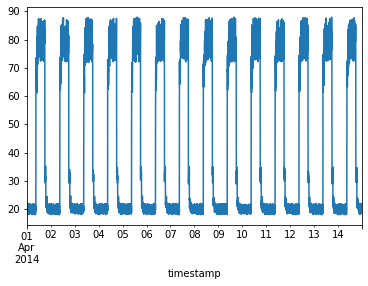

In [23]:
fig, ax = plt.subplots()
df_small_noise.plot(legend=False, ax=ax)
plt.show()

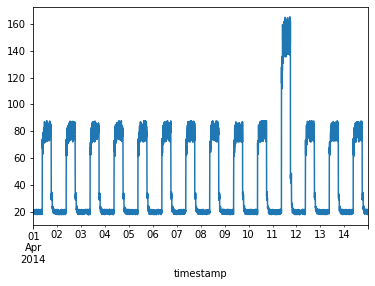

In [24]:
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
plt.show()

In [25]:
training_mean = df_small_noise.mean()
training_std = df_small_noise.std()
df_training_value = (df_small_noise - training_mean) / training_std
print("Number of training samples:", len(df_training_value))

Number of training samples: 4032


In [26]:
df_training_value.head()

,value
timestamp,
2014-04-01 00:00:00,-0.858829
2014-04-01 00:05:00,-0.728993
2014-04-01 00:10:00,-0.848148
2014-04-01 00:15:00,-0.729586
2014-04-01 00:20:00,-0.731173


In [27]:
TIME_STEPS = 288

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train = create_sequences(df_training_value.values)
print("Training input shape: ", x_train.shape)

Training input shape:  (3744, 288, 1)


## Convolutional Autoencoder model

In [30]:
modelConv = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
modelConv.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
modelConv.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 144, 32)           256       
_________________________________________________________________
dropout_2 (Dropout)          (None, 144, 32)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 72, 16)            3600      
_________________________________________________________________
conv1d_transpose_3 (Conv1DTr (None, 144, 16)           1808      
_________________________________________________________________
dropout_3 (Dropout)          (None, 144, 16)           0         
_________________________________________________________________
conv1d_transpose_4 (Conv1DTr (None, 288, 32)           3616      
_________________________________________________________________
conv1d_transpose_5 (Conv1DTr (None, 288, 1)           

## LSTM Autoencoder

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Input, Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.models import Model

from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [34]:
modelLSTM = Sequential()
modelLSTM.add(LSTM(128, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True))
modelLSTM.add(LSTM(64, activation='relu', return_sequences=False))
modelLSTM.add(RepeatVector(x_train.shape[1]))
modelLSTM.add(LSTM(64, activation='relu', return_sequences=True))
modelLSTM.add(LSTM(128, activation='relu', return_sequences=True))
modelLSTM.add(TimeDistributed(Dense(x_train.shape[2])))

modelLSTM.compile(optimizer='adam', loss='mse')
modelLSTM.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 288, 128)          66560     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 288, 64)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 288, 64)           33024     
_________________________________________________________________
lstm_3 (LSTM)                (None, 288, 128)          98816     
_________________________________________________________________
time_distributed (TimeDistri (None, 288, 1)            129       
Total params: 247,937
Trainable params: 247,937
Non-trainable params: 0
________________________________________________

In [ ]:
history = modelLSTM.fit(trainX, trainY, epochs=10, batch_size=32, validation_split=0.1, verbose=1)


In [51]:
modelLSTM2 = Sequential()
modelLSTM2.add(LSTM(128, input_shape=(x_train.shape[1], x_train.shape[2])))
modelLSTM2.add(Dropout(rate=0.2))
modelLSTM2.add(RepeatVector(x_train.shape[1]))
modelLSTM2.add(LSTM(128, return_sequences=True))
modelLSTM2.add(Dropout(rate=0.2))
modelLSTM2.add(TimeDistributed(Dense(x_train.shape[2])))

modelLSTM2.compile(optimizer='adam', loss='mae')
modelLSTM2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 288, 128)          0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 288, 128)          131584    
_________________________________________________________________
dropout_5 (Dropout)          (None, 288, 128)          0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 288, 1)            129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
________________________________________________

## Models Training

In [ ]:
modelLSTMHistory = modelLSTM.fit(x_train, x_train, epochs=50, batch_size=128, validation_split=0.1, verbose=1)

Epoch 1/50
27/27 [==============================] - 38s 1s/step - loss: 0.9953 - val_loss: 0.9999
Epoch 2/50
27/27 [==============================] - 33s 1s/step - loss: 0.9824 - val_loss: 0.9842
Epoch 3/50
27/27 [==============================] - 33s 1s/step - loss: 0.9596 - val_loss: 0.9550
Epoch 4/50
27/27 [==============================] - 33s 1s/step - loss: 0.9224 - val_loss: 0.9641
Epoch 5/50
27/27 [==============================] - 34s 1s/step - loss: nan - val_loss: nan
Epoch 6/50
23/27 [========================>.....] - ETA: 4s - loss: nan

In [ ]:
modelLSTM2History = modelLSTM2.fit(x_train, x_train, epochs=50, batch_size=128, validation_split=0.1, verbose=1)

In [52]:
modelConvHistory = modelConv.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
27/27 [==============================] - 0s 17ms/step - loss: 0.0195 - val_loss: 0.0224
Epoch 2/50
27/27 [==============================] - 0s 14ms/step - loss: 0.0186 - val_loss: 0.0236
Epoch 3/50
27/27 [==============================] - 0s 14ms/step - loss: 0.0179 - val_loss: 0.0228
Epoch 4/50
27/27 [==============================] - 0s 13ms/step - loss: 0.0172 - val_loss: 0.0227
Epoch 5/50
27/27 [==============================] - 0s 13ms/step - loss: 0.0167 - val_loss: 0.0255
Epoch 6/50
27/27 [==============================] - 0s 14ms/step - loss: 0.0161 - val_loss: 0.0223
Epoch 7/50
27/27 [==============================] - 0s 14ms/step - loss: 0.0155 - val_loss: 0.0250
Epoch 8/50
27/27 [==============================] - 0s 13ms/step - loss: 0.0151 - val_loss: 0.0247
Epoch 9/50
27/27 [==============================] - 0s 13ms/step - loss: 0.0145 - val_loss: 0.0237
Epoch 10/50
27/27 [==============================] - 0s 13ms/step - loss: 0.0140 - val_loss: 0.0230
Epoch 11/

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

## Loss 

In [42]:
def plotLoss(pred_data, real, labels=[""]):
    for i, pred in enumerate(pred_data):
        train_mae_loss = np.mean(np.abs(pred - real), axis=1)
        plt.hist(train_mae_loss, bins=50, label=labels[i])
        plt.xlabel("Train MAE loss")
        plt.ylabel("No of samples")
        # Get reconstruction loss threshold.
        threshold = np.max(train_mae_loss)
        print("Reconstruction error threshold: ", threshold)    
    plt.legend()
    plt.show()

In [47]:
autoencoder_predictions_on_training = modelConv.predict(x_train)
lstm_predictions_on_training = modelLSTM.predict(x_train)

(3744, 288, 1)


In [48]:
print(autoencoder_predictions_on_training.shape)
print(lstm_predictions_on_training.shape)

(3744, 288, 1)
(3744, 288, 1)


Reconstruction error threshold:  0.1155753186339066
Reconstruction error threshold:  0.9683227489596793


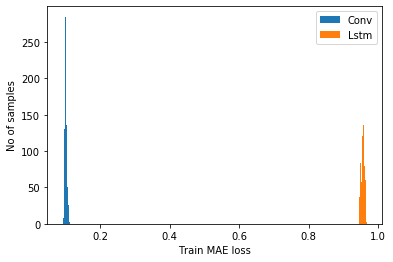

In [46]:
plotLoss([autoencoder_predictions_on_training, lstm_predictions_on_training], x_train, labels=["Conv","Lstm"])

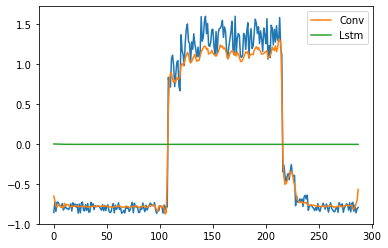

In [50]:
plt.plot(x_train[0])
plt.plot(autoencoder_predictions_on_training[0], label="Conv")
plt.plot(lstm_predictions_on_training[0], label="Lstm")
plt.legend()
plt.show()


In [ ]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

In [ ]:
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()

In [ ]:
model = keras.Sequential()
model.add(layers.LSTM(50, activation='relu', input_shape=(n_in,1)))
model.add(layers.RepeatVector(n_in))
model.add(layers.LSTM(50, activation='relu', return_sequences=True))
model.add(layers.TimeDistributed(layers.Dense(1)))
model.compile(optimizer='adam', loss='mse')
